In [1]:
import myTools, qTools, qPlots, myQiskit   # Personal utilities

import numpy as np
import matplotlib.pyplot as plt

startTime = myTools.strtime()
myJobs = []
print(f"Start at {startTime}\n")
qVersion=qTools.init_qnotebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Wed Feb  8 15:44:54 2023 UTC

Python: sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
myTools: myTools(major=1, minor=2, micro=0)

jTools: jTools(major=1, minor=0, micro=3)
Virtual Env /home/richard/jupyter/qis-rel
Working Dir: /home/richard/src/qiskit-notebooks/Qiskit-Challenges/open-science-prize-2022
qTools: qTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Qiskit Tools
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import IBMQ
service = QiskitRuntimeService(channel='ibm_quantum')
IBMQ.load_account()

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeSim = FakeGuadalupe()


In [43]:
# Import Solution Utilities
import matplotlib.pyplot as plt
from time import time
import numpy as np
import rustworkx as rx
from heisenberg_model import HeisenbergModel

from qiskit import transpile, QuantumCircuit
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.circuit.library import EfficientSU2

from qiskit.algorithms import NumPyEigensolver

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [4]:
# def rotate_point(point, theta, origin=[0,0], digits=5):
#     """
#     Rotate a point counterclockwise by a given angle around a given origin.

#     The angle should be given in degrees.
#     """
#     ox, oy = origin
#     px, py = point
#     sTheta = np.sin(np.deg2rad(theta))
#     cTheta = np.cos(np.deg2rad(theta))

#     qx = ox + cTheta * (px - ox) - sTheta * (py - oy)
#     qy = oy + sTheta * (px - ox) + cTheta * (py - oy)
#     return [qx, qy]

def SparsePauliPrint(pauli,label='Sparse Pauli'):
    cnt=0
    print(f"{label}{pauli.to_matrix().shape} as list:")
    for curItem in pauli.to_list():
        cnt+=1
        print(f"{cnt}:\t{curItem[0]} * {curItem[1]}")
    print("\n")

def print_dists(points,nPoints):
    def dist(a,b,digits=5):
        a=np.array(a)
        b=np.array(b)
        return np.around(np.linalg.norm(a-b),digits)
    for i in range(nPoints):
        for j in range(i+1,nPoints):
            print(f"dist({i},{j}) = {dist(points[i],points[j])}")

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
pos16 = {0:[1,-1], 6:[1.5,-1], 9:[2,-1],  
          1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
          13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
          8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
pos12 = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
          4:pos16[4],  5:pos16[2],  6:pos16[1],  7:pos16[5],
          8:pos16[3],  9:pos16[8], 10:pos16[11], 11:pos16[14]}
pos4  = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7], }
pos4a = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]], }
pos5  = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
          4:pos16[4], }

# Develop Full Lattice

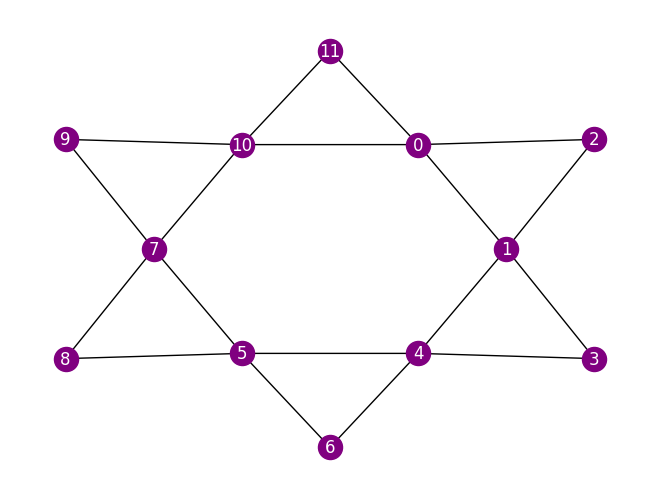

In [5]:
# Kagome unit cell
nodes_12 = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_12 = rx.PyGraph(multigraph=False)
graph_12.add_nodes_from(range(nodes_12))
edges_12 = [
    (0, 1, t),
    (0, 2, t),
    (1, 2, t),
    (1, 3, t),
    (1, 4, t),
    (3, 4, t),
    
    (4, 5, t),
    (4, 6, t),
    (5, 6, t),
    (5, 7, t),
    (5, 8, t),
    (7, 8, t),
    
    (7, 9, t),
    (7, 10, t),
    (9, 10, t),
    (10, 11, t),
    (10, 0, t),
    (11, 0, t)
]
# Generate graph from the list of edges
graph_12.add_edges_from(edges_12)

# Make a Lattice from graph
cell_12 = Lattice(graph_12)


cell_12.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':pos12})
plt.show()

In [6]:
# Solve Directly for full lattice (12 Nodes)
heis_12 = HeisenbergModel.uniform_parameters(
    lattice=cell_12,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham_12 = 4 * log_mapper.map(heis_12.second_q_ops().simplify())

from qiskit.algorithms import NumPyEigensolver
# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham_12)
print(exact_result.eigenvalues)

# Save ground state energy for later
target_12 = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


number and type of gates in the cirucit: OrderedDict([('rz', 108), ('sx', 72), ('cx', 33)])
number of parameters in the circuit: 72


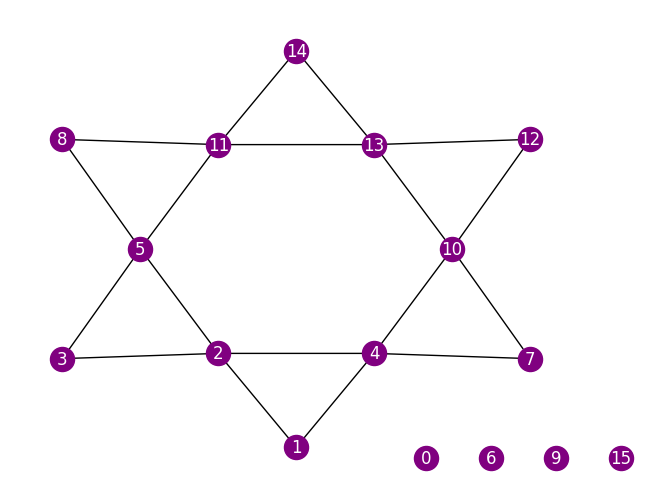

In [7]:
# Full Lattice
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
# plt.show()

# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
# ham_16
ansatz16 = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
# ansatz12.draw(fold=300)

q16_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz16_opt = transpile(ansatz16, backend=guadalupeSim, initial_layout=q16_layout)

print('number and type of gates in the cirucit:', ansatz16_opt.count_ops())
print('number of parameters in the circuit:', ansatz16_opt.num_parameters)
# ansatz_opt.draw(fold=300)

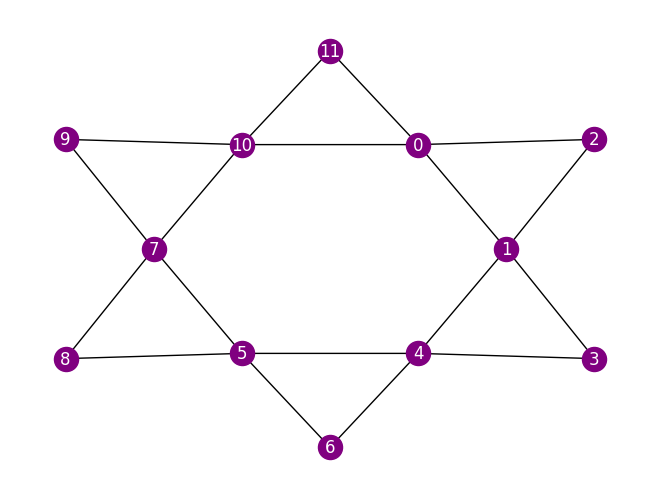

In [8]:
cell_12.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':pos12})

# Develop Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

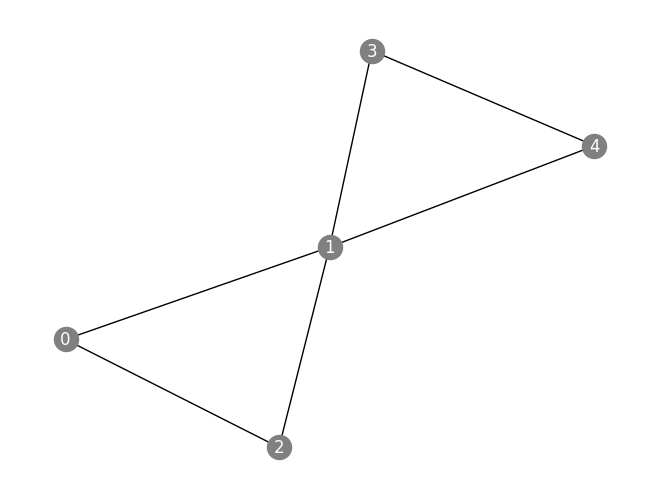

In [9]:
# Sub-Lattice (5 Nodes)
nodes_5 = 5
# Edge weight
t = 1.0
graph_5 = rx.PyGraph(multigraph=False)
graph_5.add_nodes_from(range(nodes_5))
edges_5 = [
    (0, 1, t),
    (0, 2, t),
    (2, 1, t),
    (1, 3, t),
    (3, 4, t),
    (1, 4, t)
]
# Generate graph from the list of edges
graph_5.add_edges_from(edges_5)

# Make a Lattice from graph
cell_5 = Lattice(graph_5)

# Draw Lattice
cell_5.draw(style={'node_color':'gray', 'font_color':'white','with_labels':True,
                   })

# Boundary Conditions

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

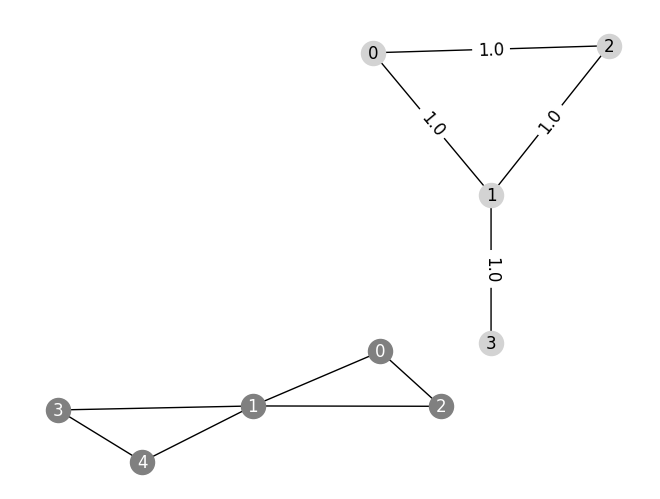

In [10]:
# Sub-Lattice with Boundary Conditions (4 nodes)
nodes_4 = 4
t = 1.0

sublat_pos = {0:[0,0], 1:[np.cos(np.deg2rad(60)),-np.sin(np.deg2rad(60))], 
              2:[1,0], 3:[1,2*-np.sin(np.deg2rad(60))], 4:[0,2*-np.sin(np.deg2rad(60))] }

# Generate graph of sub-lattice unit cell
graph_4 = rx.PyGraph(multigraph=False)
graph_4.add_nodes_from(range(nodes_4))
edges_4 = [
    (0, 1, t),
    (0, 2, t),
    (2, 1, t),
    (1, 3, t),
]
# Generate graph from the list of edges
graph_4.add_edges_from(edges_4)

# Make a Lattice from graph
cell_4 = Lattice(graph_4)
# Draw Lattice
cell_5.draw(style={'node_color':'gray', 'font_color':'white','with_labels':True,
                   })
cell_4.draw(style={'with_labels':True, 'font_color':'black', 'node_color':'lightgray', 
                              'edge_labels':str, 'pos':pos4a})

In [11]:
# Build Hamiltonian for sub-lattice (4 Nodes)
heis_4 = HeisenbergModel.uniform_parameters(
    lattice=cell_4,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No single site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_4 = 4 * log_mapper.map(heis_4.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 4 ZZ, 4 YY, and 4 XX terms over 4 qubits (12 Total Entries)
SparsePauliPrint(ham_4.primitive)

Sparse Pauli(16, 16) as list:
1:	ZIZI * (1+0j)
2:	IZZI * (1+0j)
3:	IZIZ * (1+0j)
4:	IIZZ * (1+0j)
5:	YIYI * (1+0j)
6:	IYYI * (1+0j)
7:	IYIY * (1+0j)
8:	IIYY * (1+0j)
9:	XIXI * (1+0j)
10:	IXXI * (1+0j)
11:	IXIX * (1+0j)
12:	IIXX * (1+0j)




## Adding Boundary Conditions
### Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


In [12]:
def BoundaryCondition(qbits,K,num_qubits):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.opflow.primitive_ops import PauliSumOp
    # Start with K = I
    coefs = [1.0, 1.0, 1.0]
    op = SparsePauliOp.from_sparse_list([("XX", qbits, coefs[0]), 
                                         ("YY", qbits, coefs[1]),
                                         ("ZZ", qbits, coefs[2])] ,num_qubits=num_qubits)
    H = PauliSumOp(op)
    return H


In [13]:
# Create the addtional terms for the Case 1 Hamiltonian
from qiskit.opflow import X, Y, Z, I

# H1_1_4 = 1.0*(I^I^Z^Z) + 1.0*(I^I^Y^Y) + 1.0*(I^I^X^X)
# H1_3_4 = 1.0*(Z^I^I^Z) + 1.0*(Y^I^I^Y) + 1.0*(X^I^I^X)
# H1 = H1_1_4 + H1_3_4
# ham_4_1 = ham_4 + HC 
# SparsePauliPrint(H1.primitive,label='Additional Hamiltonian Terms')
# SparsePauliPrint(ham_4_1.primitive,label='Full Hamiltonian')

H_BC_1 = BoundaryCondition([0,1],I,4) + BoundaryCondition([0,3],I,4)
ham_4_full = ham_4 + H_BC_1
SparsePauliPrint(H_BC_1.primitive,label='Additional Terms')
SparsePauliPrint(ham_4_full.primitive,label='Full Hamiltonian')

Additional Terms(16, 16) as list:
1:	IIXX * (1+0j)
2:	IIYY * (1+0j)
3:	IIZZ * (1+0j)
4:	XIIX * (1+0j)
5:	YIIY * (1+0j)
6:	ZIIZ * (1+0j)


Full Hamiltonian(16, 16) as list:
1:	ZIZI * (1+0j)
2:	IZZI * (1+0j)
3:	IZIZ * (1+0j)
4:	IIZZ * (1+0j)
5:	YIYI * (1+0j)
6:	IYYI * (1+0j)
7:	IYIY * (1+0j)
8:	IIYY * (1+0j)
9:	XIXI * (1+0j)
10:	IXXI * (1+0j)
11:	IXIX * (1+0j)
12:	IIXX * (1+0j)
13:	IIXX * (1+0j)
14:	IIYY * (1+0j)
15:	IIZZ * (1+0j)
16:	XIIX * (1+0j)
17:	YIIY * (1+0j)
18:	ZIIZ * (1+0j)




### Compute ground state energy
With the modified Hamiltonian in hand, we can calculate the expected ground state and its energy as a sanity check. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

In [14]:
# find all eigenvalues for the sub-lattice Boundary Conditions (Case 1)
exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(ham_4_full)
print(exact_result.eigenvalues)

[-6. -6. -6. -6. -6. -2. -2. -2.  2.  2.  2.  6.  6.  6.  6.  6.]


## Map Sub-Lattice to qubits

## Map Sub-Lattice to 7 qubit systems (Nairobi or Oslo)

Available backends
	ibmq_manila
	ibmq_qasm_simulator
	ibmq_quito
	ibmq_lima
	ibmq_belem
	simulator_extended_stabilizer
	simulator_mps
	simulator_statevector
	simulator_stabilizer
	ibm_oslo
	ibm_nairobi


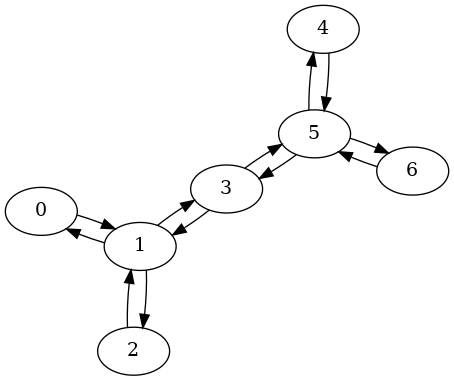

In [15]:
provider, lservice = qTools.get_provider()
simulator = provider.get_backend('simulator_statevector')
nairobi = provider.get_backend('ibm_nairobi')
desc, image = myQiskit.backend_description(nairobi,output=False)
image

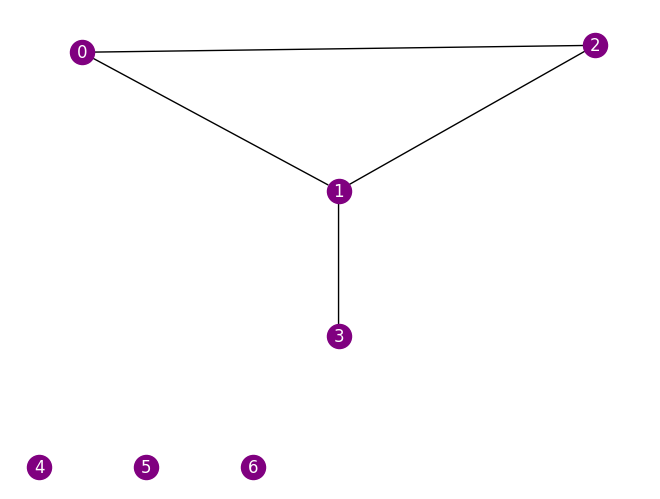

In [16]:
# Sub-Lattice (4 nodes) on 7-qubit System (Nairobi/Oslo)
num_qubits = 7
# Edge weight
t = 1.0
pos7 = pos4a
pos7[4]=[0.5, -1]
pos7[5]=[0.75,-1]
pos7[6]=[1.0, -1]

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_7 = rx.PyGraph(multigraph=False)
graph_7.add_nodes_from(range(num_qubits))

# Generate graph from the list of edges
graph_7.add_edges_from(edges_4)

# Make a Lattice from graph
cell_7 = Lattice(graph_7)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
cell_7.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':pos7})

In [17]:
# Build Sub-Lattice Hamiltonian for 7 qubit system
heis_7 = HeisenbergModel.uniform_parameters(
    lattice=cell_7,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No single site external field
)

# Map from SpinOp
log_mapper = LogarithmicMapper()
ham_7 = 4 * log_mapper.map(heis_7.second_q_ops().simplify())
H7_C1 = BoundaryCondition([0,1],I,7) + BoundaryCondition([3,0],I,7)
# SparsePauliPrint(ham_7.primitive,label='Initial 7 qbit Hamiltonian')
# SparsePauliPrint(H7_C1.primitive,label='Additional Terms')
ham_7_1 = ham_7 + H7_C1
SparsePauliPrint(ham_7_1.primitive,label='Full Hamiltonian Case 1')

Full Hamiltonian Case 1(128, 128) as list:
1:	IIIZIZI * (1+0j)
2:	IIIIZZI * (1+0j)
3:	IIIIZIZ * (1+0j)
4:	IIIIIZZ * (1+0j)
5:	IIIYIYI * (1+0j)
6:	IIIIYYI * (1+0j)
7:	IIIIYIY * (1+0j)
8:	IIIIIYY * (1+0j)
9:	IIIXIXI * (1+0j)
10:	IIIIXXI * (1+0j)
11:	IIIIXIX * (1+0j)
12:	IIIIIXX * (1+0j)
13:	IIIIIXX * (1+0j)
14:	IIIIIYY * (1+0j)
15:	IIIIIZZ * (1+0j)
16:	IIIXIIX * (1+0j)
17:	IIIYIIY * (1+0j)
18:	IIIZIIZ * (1+0j)




# Custom Solution Components

In [115]:
def callback(value):  # Here for older saved object versions
    return None

def save_object(obj,fname):
    import pickle
    with open(fname, 'wb') as obj_file:
        pickle.dump(obj, obj_file)

def load_object(fname):
    import pickle
    with open(fname, 'rb') as obj_file:
        obj = pickle.load(obj_file)
    return obj

def formatDuration(duration):
    days    = divmod(duration, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)          # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)           # Use remainder of hours to calc minutes
    msg = ''
    if int(days[0]) > 0:
        msg += f"{int(days[0])} days, {int(hours[0])} hours, {int(minutes[0])} min"
    elif int(hours[0]) > 0:
        msg += f"{int(hours[0])} hours, {int(minutes[0])} min"
    elif int(minutes[0]) > 0:
        msg += f"{int(minutes[0])} min, {int(minutes[1])} sec"
    else:
        msg += f"{np.around(minutes[1],5)} sec"
    return msg


In [213]:
from qiskit.algorithms import MinimumEigensolver, VQEResult
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.jobstatus import JobStatus 
_runningJobs = [JobStatus.INITIALIZING, 
                JobStatus.QUEUED, 
                JobStatus.VALIDATING,
                JobStatus.RUNNING, ]
_doneJobs    = [JobStatus.CANCELLED, JobStatus.DONE, JobStatus.ERROR, ]

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, timeout=120, target=None,
                label=None):
        self._estimator     = estimator
        self._circuit       = circuit
        self._optimizer     = optimizer
        self._timeout       = timeout
        self._target        = target
        self._callback_data = []
        self._result        = None
        self._initial_point = None
        self._label         = label
      
    def _callback(self, value):
        self._callback_data.append(value)

    @property
    def callback_data(self):
        return self._callback_data
    
    @property
    def initial_point(self):
        return self._initial_point
    
    @property
    def label(self):
        return self._label
    
    @property
    def result(self):
        return self._result
    
    @property
    def target(self) -> int | None:
        return self._target
    
    def __repr__(self):
        return(f"{self._label}"
               f"{self._target}\n"
               f"{self._initial_point}"
               f"{self._callback_data}"
               f"{self._result}")
        
    def __str__(self):
        return(f"{self._label}\n"
               f"Target: {self._target}\n"
               f"Result:\n{self._result}\n"
               f"InitialPoint:\n{self._initial_point}\n"
               f"Callback Data:\n{self._callback_data}\n")
        
    def list_result(self):
        msg =  f"'{self.label}' "
        msg += f"\tComputed: {np.around(self._result.eigenvalue,3)}"
        if self._target is not None:
            rel_error = abs((self._target - self._result.eigenvalue) / self._target)
            msg += f"\tTarget:   {np.around(self.target,3)}"
            msg += f"\tError {np.around(100*rel_error,3)}%"
        return msg
        
    def show_result(self):
        eigenvalue = self._result.eigenvalue
        print(f'Computed ground state energy: {eigenvalue:.10f}')
        plt.title(self._label)
        plt.plot(self._callback_data, color='purple', lw=2)
        plt.ylabel('Energy')
        plt.xlabel('Iterations')
        if self._target is not None:
            rel_error = abs((self._target - eigenvalue) / self._target)
            print(f'Expected ground state energy: {self._target:.10f}')
            print(f'Relative error: {np.around(100*rel_error,8)}%')
            plt.axhline(y=self._target, color="tab:red", ls="--", lw=2, label="Target: " + str(self._target))
        else:
            plt.axhline(y=eigenvalue, color="tab:red", ls="--", lw=2, label="Target: None" )
        plt.legend()
        plt.grid()
        plt.show()    

    def compute_minimum_eigenvalue(self, operators, aux_operators=None, x0=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            try_count = 0
            job_result = None
            start = time()
            while (job_result is None) and (try_count < 2):
                try_count += 1
                jobId = 'UNK'
                try:
                    job = self._estimator.run([self._circuit], [operators], [x])
                    jobId = job.job_id()
                    job_status = job.status()
                    if (job_status is not JobStatus.DONE) and (job_status not in _runningJobs):
                        print(f"Job:{jobId} Try:{try_count} Status:{job_status} T:{time()-start}sec")
                    elif self._timeout is not None:
                        job_result = job.result(timeout=self._timeout)
                    else:
                        job_result = job.result()
                
                except JobError as ex:
                    print(f"Job:{jobId} Try:{try_count} Status:{job_status} T:{time()-start}sec")
                    print(f"Job {jobId} Try {try_count} Error {ex}")
                    if try_count < 2:
                        pass
                    else:
                        raise ex
                
            # Get the measured energy value
            value = job_result.values[0]
            # Save result information 
            self._callback_data.append(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if x0 is None:
            x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        self._initial_point = x0
        
        result = VQEResult()
        
        # Run optimization
        start = time()
        res = self._optimizer.minimize(objective, x0=x0)
        result.optimizer_time = time()-start
        
        # Populate VQE result
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.optimizer_result = res
        result.optimal_point = np.array(self._callback_data)
        
        # Update Custom VQE Data
        self._result = result
        return result

def list_results(result):
    results = result
    if not isinstance(results,list):
        results = [result]
    for idx in range(len(results)):
        custom_vqe = results[idx]
        print(f"{idx}: {custom_vqe.list_result()}")
    print("\n")
        
def load_customVQE(fname):
    import os.path
    if os.path.isfile(fname):
        results = load_object(fname)
    else:
        print(f"File not found.")
        
        results = []
    print(f"Loaded {len(results)} results")
    return results

def save_customVQE(obj,fname):
    estimators = []
    objList = obj
    if not isinstance(obj,list):
        objList = [obj]
    # runtime estimator causes recursion error on load    
    for curObj in objList:
        estimators.append(curObj._estimator)        
        curObj._estimator = None
        
    # save the list
    save_object(objList,fname)
    
    # restore the estimator
    if isinstance(obj,list):
        for idx in range(len(estimators)):
            obj[idx]._estimator = estimators[idx]
    else:
        obj._estimator = estimators[0]
        
def runCustomVQE(H, ansatz, optimizer, timeout=120, x0=None, target = None,
                 resultsList=None, service=None, backend=None, label=None):
    if label is None:
        label = "CustomVQE"
    if resultsList is not None:
        label += f" {len(resultsList)}" 
        
    if backend is None:
        from qiskit.primitives import Estimator
        
        estimator = Estimator([ansatz], [H])
        label += f" Local {optimizer.__class__.__name__}"
        print(label)
        custom_vqe = CustomVQE(estimator, ansatz, optimizer,  
                               timeout=None, target=target, label=label)
        result = custom_vqe.compute_minimum_eigenvalue(H,x0=x0)
    else:
        from qiskit_ibm_runtime import Session, Estimator as RuntimeEstimator
        
        with Session(service=service, backend=backend) as session:
            label += f" {backend} {optimizer.__class__.__name__}"
            print(label)
            estimator = RuntimeEstimator(session=session)
            custom_vqe = CustomVQE(estimator, ansatz, optimizer,
                                   timeout=timeout, target=target, label=label)
            result = custom_vqe.compute_minimum_eigenvalue(H,x0=x0)
    
    if resultsList is not None:
        resultsList.append(custom_vqe)
        
    print(f"Runtime {formatDuration(result.optimizer_time)}")
    return custom_vqe

# Setup for Runs
## Data Files, Ansatz and Optimizers

ansatz4_custom gates in the circuit: OrderedDict([('cx', 5), ('rz', 4), ('ry', 4), ('h', 2)])
ansatz4_custom parameters in the circuit: 8 

ansatz12_custom gates in the circuit: OrderedDict([('cx', 17), ('rz', 12), ('ry', 12), ('h', 6)])
ansatz12_custom parameters in the circuit: 24


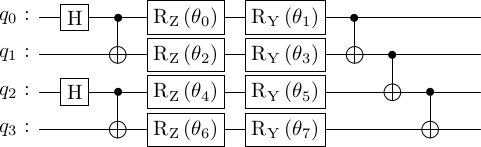

In [446]:
# Build a custom ansatz from scratch
def customAnsatz(num_qubits):
    from qiskit.circuit import Parameter
    ansatz_custom = QuantumCircuit(num_qubits)
    # build initial state
    ansatz_custom.h(range(0, num_qubits, 2))
    ansatz_custom.cx(range(0, num_qubits-1, 2), range(1, num_qubits, 2))
    # First layer
    j = 0
    for i in range(num_qubits):
        ansatz_custom.rz(Parameter('θ_' + str(j)), i)
        j += 1
        ansatz_custom.ry(Parameter('θ_' + str(j)), i)
        j += 1
    ansatz_custom.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz_custom

ansatz12_custom = customAnsatz(12)
ansatz4_custom = customAnsatz(4)
print('ansatz4_custom gates in the circuit:', ansatz4_custom.count_ops())
print('ansatz4_custom parameters in the circuit:', ansatz4_custom.num_parameters,"\n")
print('ansatz12_custom gates in the circuit:', ansatz12_custom.count_ops())
print('ansatz12_custom parameters in the circuit:', ansatz12_custom.num_parameters)
ansatz4_custom.draw('latex')

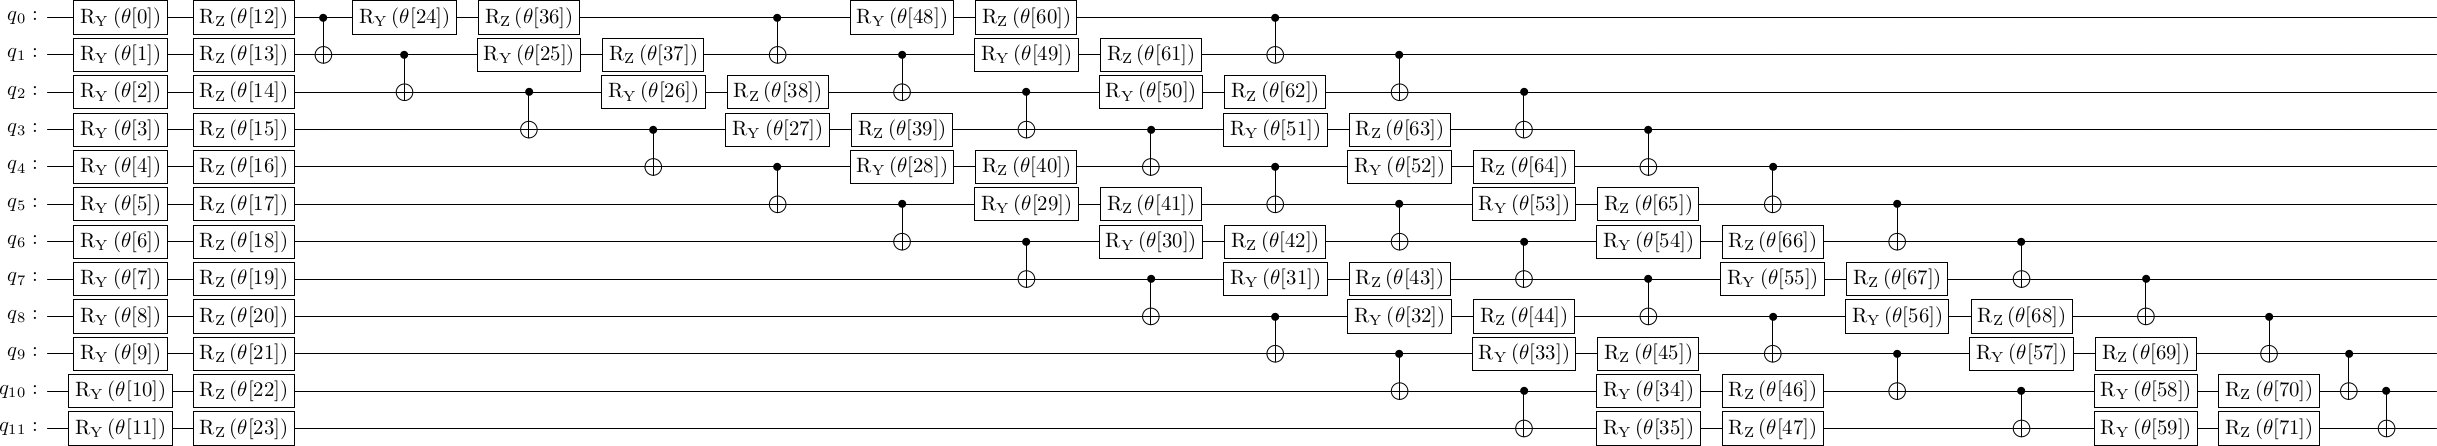

In [52]:
ansatzS2_4 = EfficientSU2(4, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
ansatzS2_4.draw(fold=300)
ansatzS2_12 = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
ansatzS2_12.draw('latex',fold=300)

ansatz4 gates in the circuit: OrderedDict([('rz', 36), ('sx', 24), ('cx', 16)])
ansatz4 parameters in the circuit: 24
ansatz4 gates in the circuit: OrderedDict([('rz', 16), ('sx', 10), ('cx', 8)])
ansatz4 parameters in the circuit: 8 

ansatz12_opt gates in the circuit: OrderedDict([('rz', 108), ('sx', 72), ('cx', 33)])
ansatz12_opt parameters in the circuit: 72
ansatz4 gates in the circuit: OrderedDict([('rz', 48), ('sx', 30), ('cx', 17)])
ansatz4 parameters in the circuit: 24


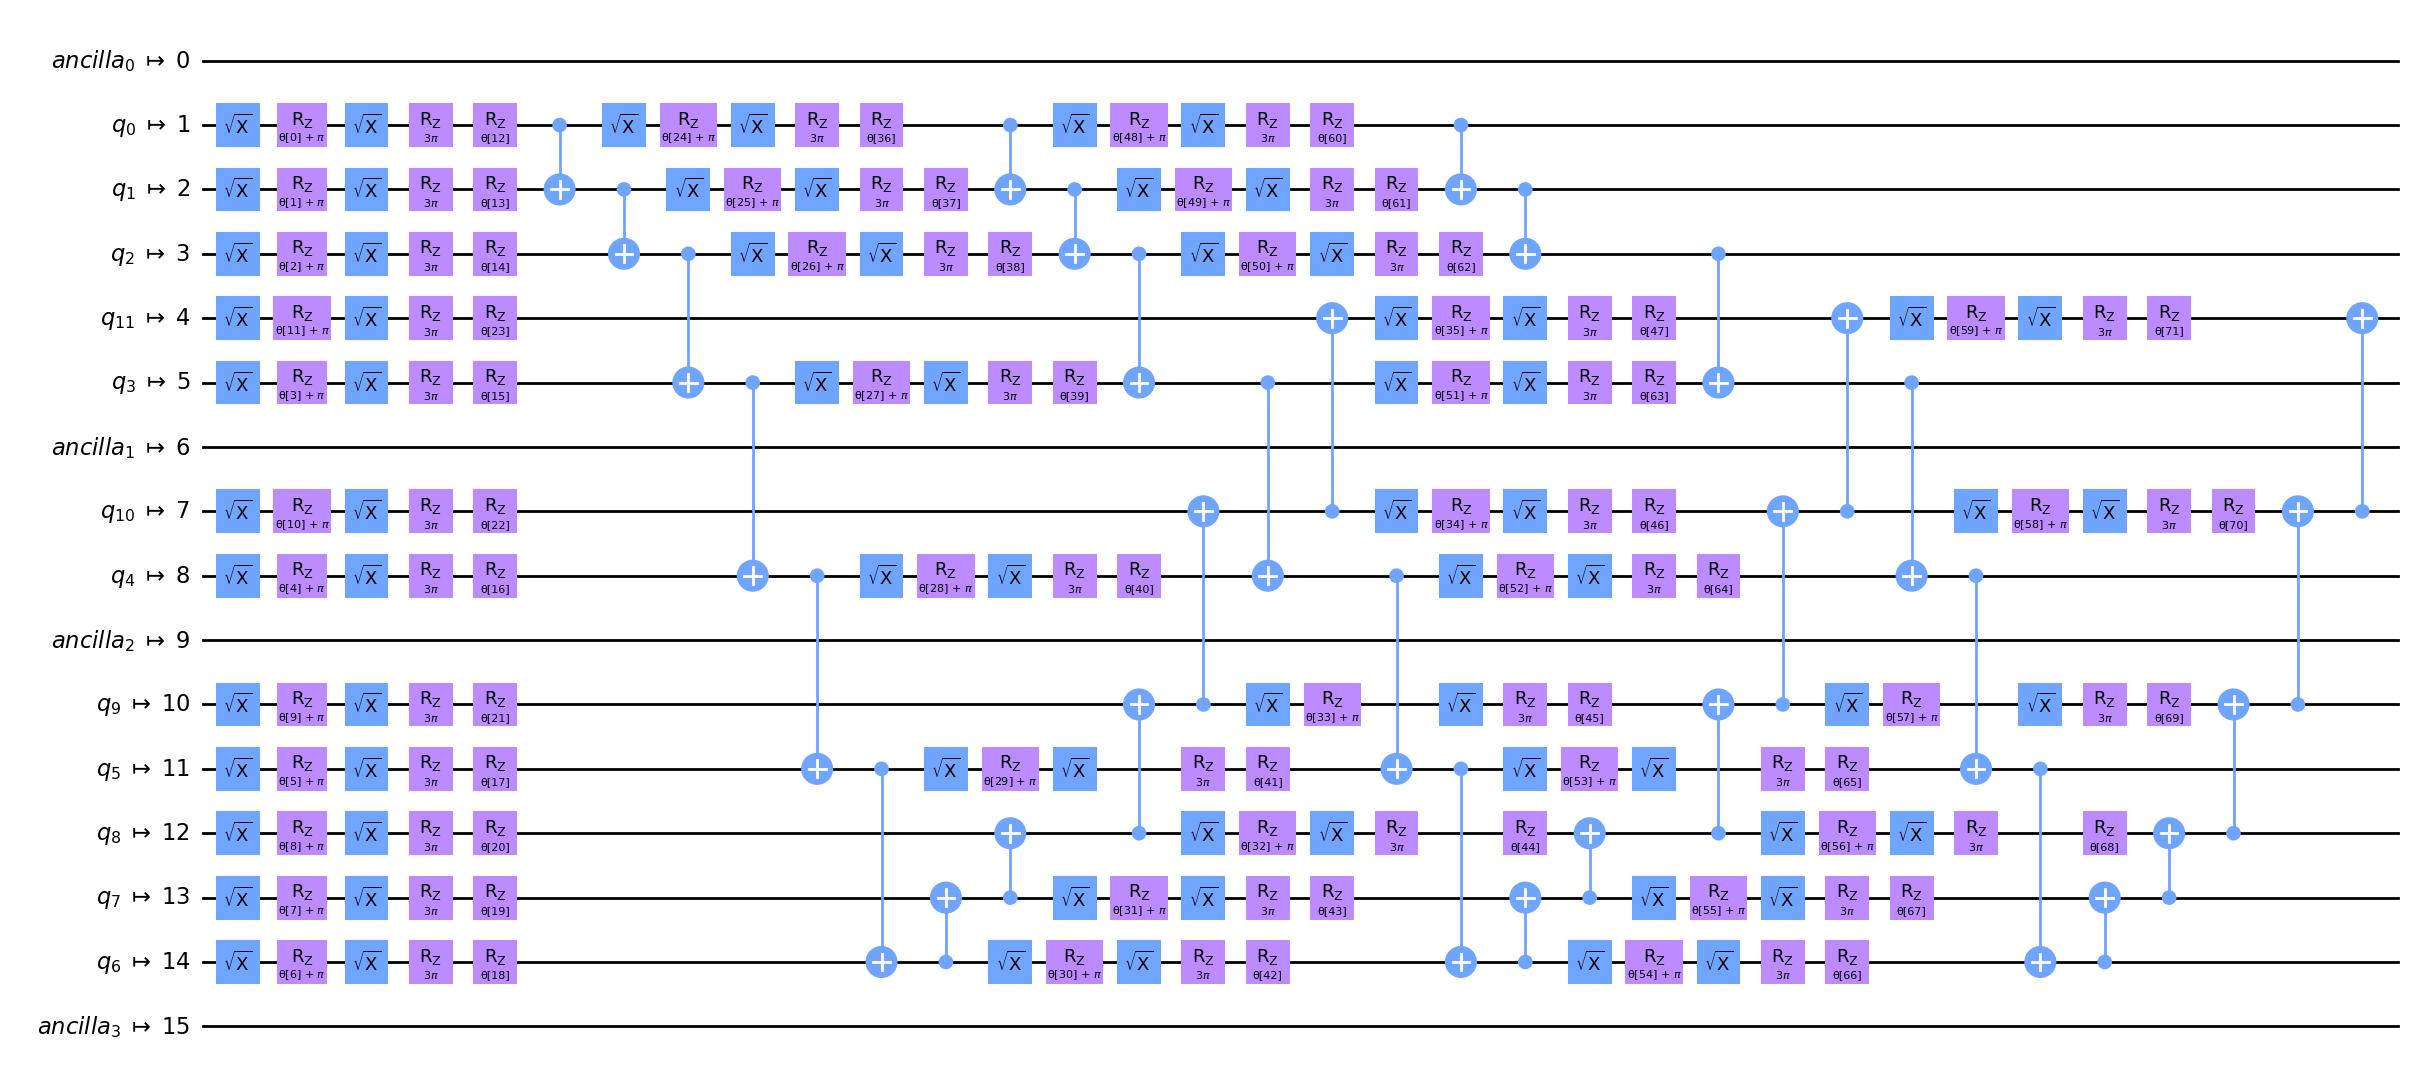

In [83]:
q4_layout = [0,1,2,3]
ansatz4_opt = transpile(ansatzS2_4, backend=nairobi, initial_layout=q4_layout)
print('ansatz4 gates in the circuit:', ansatz4_opt.count_ops())
print('ansatz4 parameters in the circuit:', ansatz4_opt.num_parameters)

ansatz4_custom_opt = transpile(ansatz4_custom, backend=nairobi, initial_layout=q4_layout)
print('ansatz4 gates in the circuit:', ansatz4_custom_opt.count_ops())
print('ansatz4 parameters in the circuit:', ansatz4_custom_opt.num_parameters,"\n")


q12_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz12_opt = transpile(ansatzS2_12, backend=guadalupeSim, initial_layout=q12_layout)
print('ansatz12_opt gates in the circuit:', ansatz12_opt.count_ops())
print('ansatz12_opt parameters in the circuit:', ansatz12_opt.num_parameters)

q12_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz12_custom_opt = transpile(ansatz12_custom, backend=guadalupeSim, initial_layout=q12_layout)
print('ansatz4 gates in the circuit:', ansatz12_custom_opt.count_ops())
print('ansatz4 parameters in the circuit:', ansatz12_custom_opt.num_parameters)

ansatz12_opt.draw(fold=300)

In [108]:
# File Names
fnameFull     = 'FullLatticeResults.dump'
fnameSub      = 'SubLatticeResults.dump'

In [23]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
service = QiskitRuntimeService(channel='ibm_quantum')

from qiskit.algorithms.optimizers import SPSA
SPSA_optimizer_01 = SPSA(maxiter=75)
optimizer01_label = 'SPSA(75)'

# --------------------- Solutions -----------------------------

# Full Lattice - Local and Cloud

### Custom Ansatz

In [216]:
FullResults = load_customVQE(fnameFull)
# FullResults = []

Loaded 1 results


In [214]:
# Local Simulator
H = ham_16
target = -18.0
custom_vqe = runCustomVQE(H, ansatz12_custom_opt, SPSA_optimizer_01, 
                          timeout=120, x0=None, target=target,
                          service=None, backend=None, 
                          resultsList=FullResults,
                          label=f"Cust01 {optimizer01_label}")
save_object(FullResults,fnameFull)

Cust01 SPSA(75) 0 Local SPSA
Runtime 23.472 sec


0: 'Cust01 SPSA(75) 0 Local SPSA' 	Computed: -6.596	Target:   -18.0	Error 63.354%


Computed ground state energy: -6.5962961359
Expected ground state energy: -18.0000000000
Relative error: 63.35391036%


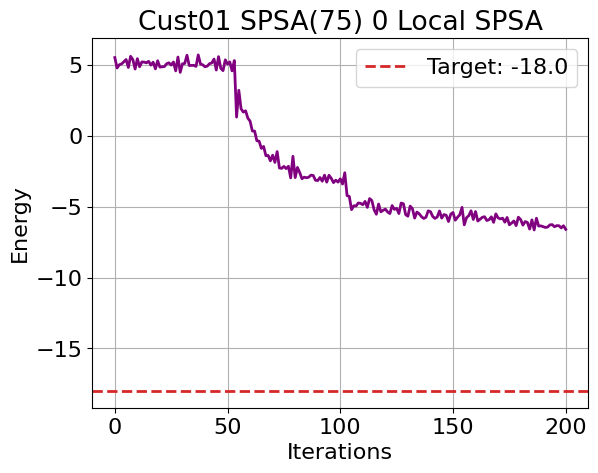

In [215]:
list_results(FullResults)
FullResults[-1].show_result()

### Efficient SU2 Ansatz

In [222]:
FullResults = load_customVQE(fnameFull)

Loaded 2 results


In [218]:
# Local Simulator
H = ham_16
target = -18.0
label = f"SU2 {optimizer01_label}"
custom_vqe = runCustomVQE(H, ansatz16_opt, SPSA_optimizer_01, 
                          service=None, backend=None, 
                          timeout=180, x0=None, target=-18,
                          resultsList=FullResults,
                          label=label )
save_object(FullResults,fnameFull)

SU2 SPSA(75) 1 Local SPSA
Runtime 42.404 sec


In [ ]:
# Cloud Solver
H = ham_16
target = -18.0
label = f"SU2   {optimizer01_label}"
custom_vqe = runCustomVQE(H, ansatz16_opt, SPSA_optimizer_01,
                          service=service, backend='simulator_statevector',
                          timeout=180, x0=None, target=-18,
                          resultsList=FullResults,
                          label=label)
save_object(FullResults,fnameFull)

0: 'Cust01 SPSA(75) 0 Local SPSA' 	Computed: -6.596	Target:   -18.0	Error 63.354%
1: 'SU2 SPSA(75) 1 Local SPSA' 	Computed: -7.036	Target:   -18	Error 60.911%


Computed ground state energy: -7.0359910614
Expected ground state energy: -18.0000000000
Relative error: 60.91116077%


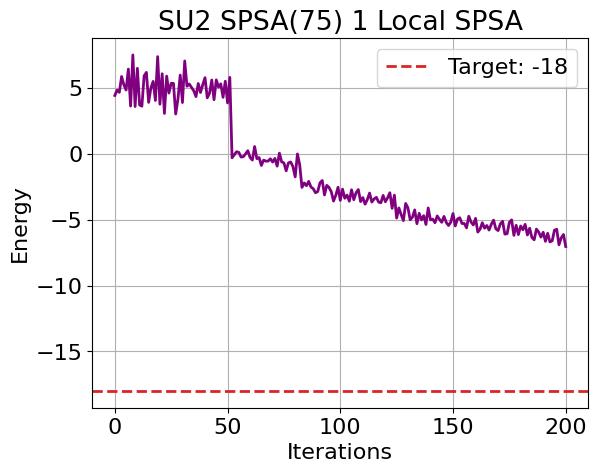

In [219]:
list_results(FullResults)
FullResults[-1].show_result()

# Sub-Lattice - Local

### Custom Ansatz - Local

In [223]:
SubResults = load_customVQE(fnameSub)

File not found.
Loaded 0 results


In [455]:
# Local Simulation
H = ham_7_1
target = -6.0
label = f"Cust01 {optimizer01_label}"
custom_vqe = runCustomVQE(H, ansatz4_custom_opt, SPSA_optimizer_01, 
                          timeout=180, x0=None, target=-6,
                          service=None, backend=None,
                          resultsList=SubResults,
                          label=label )
save_customVQE(SubResults,fnameSub)

Cust01 SPSA(75) 9 Local SPSA
Runtime 1.0831 sec


0: 'Cust01 SPSA(75) 0 Local SPSA' 	Computed: -2.191	Target:   -6	Error 63.478%
1: 'SU2   SPSA(75) 1 Local SPSA' 	Computed: -5.171	Target:   -6	Error 13.815%
2: 'SU2   SPSA(75) 2 Local SPSA' 	Computed: -4.68	Target:   -6	Error 21.995%
3: 'SU2    SPSA(75) 3 Local SPSA' 	Computed: -5.058	Target:   -6	Error 15.702%
4: 'SU2    SPSA(75) 4 simulator_statevector SPSA' 	Computed: -5.573	Target:   -6	Error 7.117%
5: 'Cust01 SPSA(75) 5 Local SPSA' 	Computed: -2.231	Target:   -6	Error 62.811%
6: 'Cust01 SPSA(75) 6 Local SPSA' 	Computed: -2.239	Target:   -6	Error 62.684%
7: 'Cust01 SPSA(75) 7 Local SPSA' 	Computed: -2.236	Target:   -6	Error 62.735%
8: 'Cust01 SPSA(75) 8 Local SPSA' 	Computed: -2.23	Target:   -6	Error 62.837%
9: 'Cust01 SPSA(75) 9 Local SPSA' 	Computed: -2.003	Target:   -6	Error 66.617%


Computed ground state energy: -2.2359184775
Expected ground state energy: -6.0000000000
Relative error: 62.73469204%


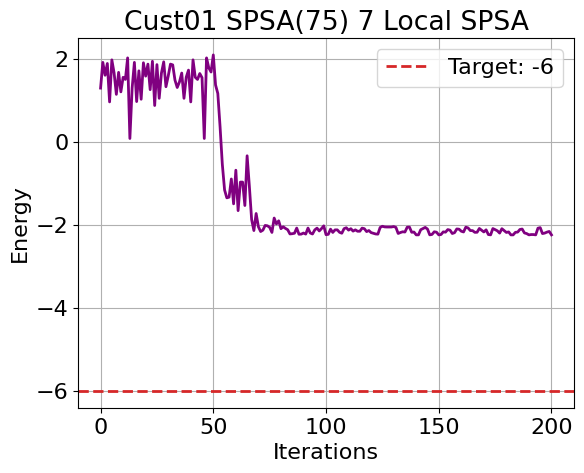

In [458]:
list_results(SubResults)
SubResults[7].show_result()

### Efficient SU2 Ansatz - Local

In [227]:
SubResults = load_customVQE(fnameSub)

Loaded 1 results


In [231]:
# Local Simulation
H = ham_7_1
target = -6.0
label =f"SU2    {optimizer01_label}"
custom_vqe = runCustomVQE(H, ansatz4_opt, SPSA_optimizer_01, 
                          timeout=180, x0=None, target=-6,
                          service=None, backend=None, 
                          resultsList=SubResults,
                          label=label)
save_customVQE(SubResults,fnameSub)

SU2    SPSA(75) 3 Local SPSA
Runtime 1.40733 sec


0: 'Cust01 SPSA(75) 0 Local SPSA' 	Computed: -2.191	Target:   -6	Error 63.478%
1: 'SU2   SPSA(75) 1 Local SPSA' 	Computed: -5.171	Target:   -6	Error 13.815%
2: 'SU2   SPSA(75) 2 Local SPSA' 	Computed: -4.68	Target:   -6	Error 21.995%
3: 'SU2    SPSA(75) 3 Local SPSA' 	Computed: -5.058	Target:   -6	Error 15.702%


Computed ground state energy: -5.0578662539
Expected ground state energy: -6.0000000000
Relative error: 15.7022291%


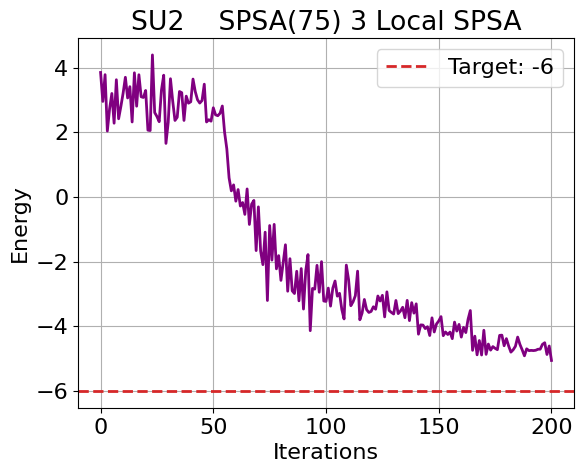

In [232]:
list_results(SubResults)
SubResults[-1].show_result()

## Efficient SU2 - Cloud

In [234]:
SubResults = load_customVQE(fnameSub)

Loaded 4 results


In [235]:
# Cloud Solution
H = ham_7_1
target = -6.0
label =f"SU2    {optimizer01_label}"
custom_vqe = runCustomVQE(H, ansatz4_opt, SPSA_optimizer_01, 
                          service=service, backend='simulator_statevector', 
                          timeout=180, x0=None, target=-6,
                          resultsList=SubResults,
                          label=label)
save_customVQE(SubResults,fnameSub)

SU2    SPSA(75) 4 simulator_statevector SPSA
Runtime 1 hours, 14 min


0: 'Cust01 SPSA(75) 0 Local SPSA' 	Computed: -2.191	Target:   -6	Error 63.478%
1: 'SU2   SPSA(75) 1 Local SPSA' 	Computed: -5.171	Target:   -6	Error 13.815%
2: 'SU2   SPSA(75) 2 Local SPSA' 	Computed: -4.68	Target:   -6	Error 21.995%
3: 'SU2    SPSA(75) 3 Local SPSA' 	Computed: -5.058	Target:   -6	Error 15.702%
4: 'SU2    SPSA(75) 4 simulator_statevector SPSA' 	Computed: -5.573	Target:   -6	Error 7.117%


Computed ground state energy: -5.5730000000
Expected ground state energy: -6.0000000000
Relative error: 7.11666667%


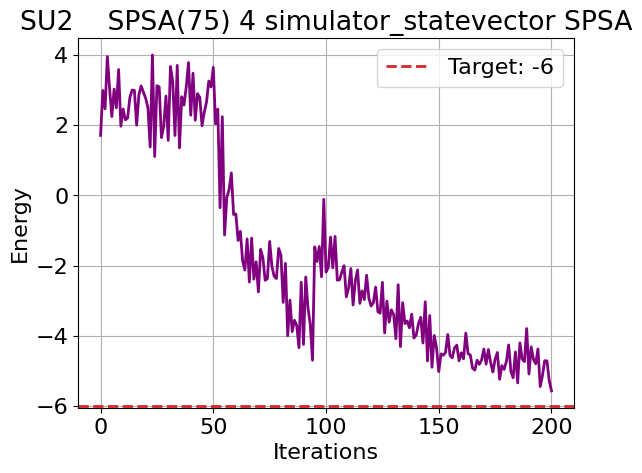

In [397]:
list_results(SubResults)
SubResults[4].show_result()

# Build Ansantz Starting Point

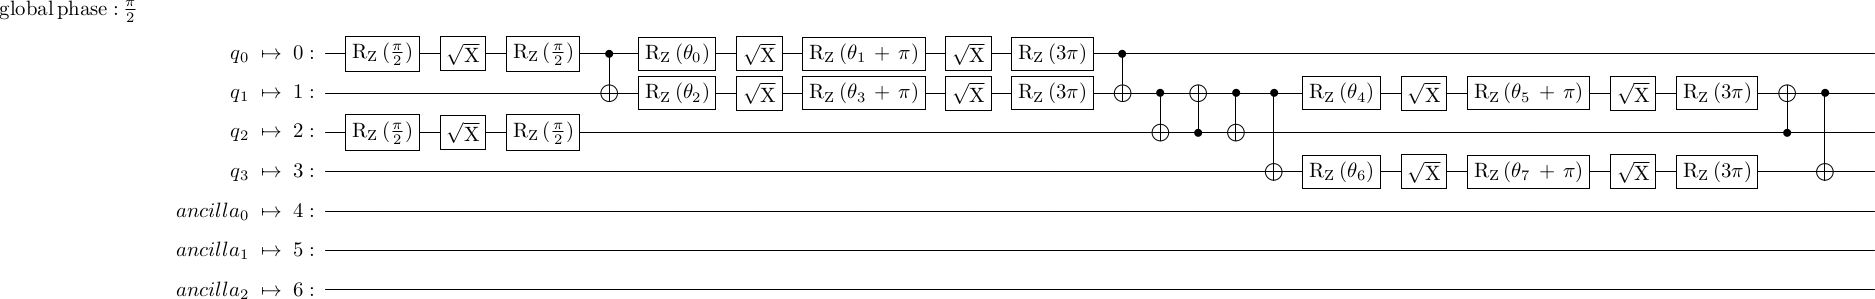

In [238]:
SubResults[0]._circuit.draw('latex')

In [417]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

def VQE2Statevector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe._circuit.assign_parameters(custom_vqe._result.optimal_parameters)
    qc.save_statevector()
    result = sim.run(qc).result()
    state_vector = result.get_statevector()
    return state_vector

def getBlochCoords(state_vector,qubit):
    num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi])
    return angles

def getCoords(state_vector):
    coords = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi

def bloch2cart(pt):
    (r,theta,phi) = np.real(pt)
    xy = r*np.sin(theta)
    x  = xy*np.cos(phi)
    y  = xy*np.sin(phi)
    z  = r*np.cos(theta)
    return x, y, z

def bloch2circuit(angles,nqubits):
    qc = QuantumCircuit(nqubits)
    if len(angles) < nqubits:
        nqubits = len(angles)
    for nbit in range(nqubits):
        (theta, phi) = angles[nbit]
        qc.ry(theta,nbit)
        qc.rz(phi,nbit)
    return qc

def bloch2Statevector(angles,nqubits=None):
    if nqubits is None:
        nqubits = len(angles)
    qc = bloch2circuit(angles,nqubits)
    return Statevector(qc)

def getNormedState(custom_vqe,nqubits=None):
    init_svector = VQE2Statevector(custom_vqe)
    angles = getBlochAngles(init_svector)
    normed_svector = bloch2Statevector(angles,nqubits=nqubits)
    return normed_svector


In [399]:
import jTools
jTools.cellOutputAll()

Cust01 SPSA(75) 9 Local SPSA: -2.00295 Initial State Energy Level
---------------------
Cust01 SPSA(75) 9 Local SPSA: -2.03401 Normalized State Energy Level


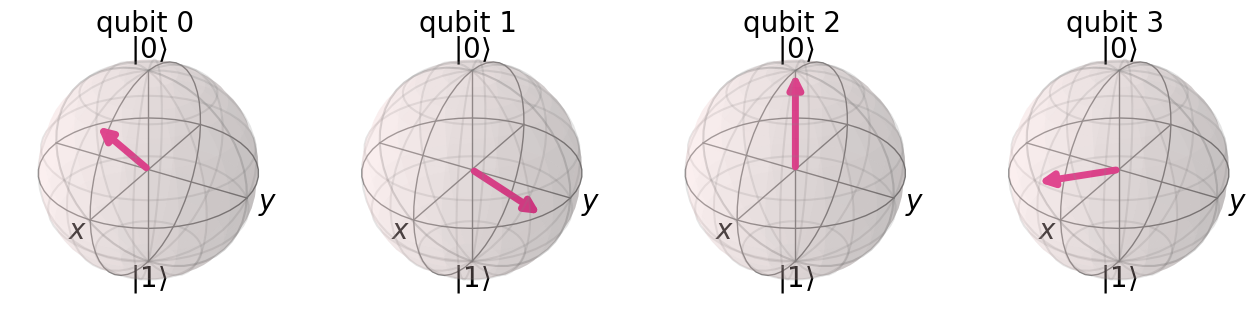

In [461]:
def displayNormedData(custom_vqe,H,nqubits=None):
    svector = VQE2Statevector(custom_vqe)
    expSvector = np.real(svector.expectation_value(H))
    normed_svector = getNormedState(custom_vqe)
    coords = np.real(getCoords(normed_svector))
    expNormed = np.real(normed_svector.expectation_value(H))

    print(f"{myList[idx].label}: {np.around(expSvector,5)} Initial State Energy Level")
    print("---------------------")
    print(f"{myList[idx].label}: {np.around(expNormed,5)} Normalized State Energy Level")

    return plot_bloch_multivector(getNormedState(myList[idx],nqubits=nqubits))
    
idx = 9
myList = SubResults
displayNormedData(SubResults[idx],ham_7_1,nqubits=4)